# Pre-proccessing via matrix factorization basic idea tests

In [13]:
from juliacall import Main as jl
jl.seval("""
         import Pkg
         ENV["JULIA_SSL_CA_ROOTS_PATH"]=""
         ENV["JULIA_PKG_USE_CLI_GIT"]=true
         Pkg.add(url=\"https://github.com/MPF-Optimization-Laboratory/KLLS.jl.git\")
         """)

    Updating git-repo `https://github.com/MPF-Optimization-Laboratory/KLLS.jl.git`
   Resolving package versions...
  No Changes to `C:\Users\mking\.julia\environments\pyjuliapkg\Project.toml`
  No Changes to `C:\Users\mking\.julia\environments\pyjuliapkg\Manifest.toml`


In [14]:
from keras.datasets import mnist
(data, labels), (_, _) = mnist.load_data()
data = data/255;

import numpy as np
import matplotlib.pyplot as plt
import random as rd
from scipy import linalg as la
from sklearn.utils.extmath import randomized_svd
import sklearn.decomposition as skd
from sklearn import random_projection as rproj
from scipy import optimize
import gc

# Vectorization of data.
vec_data = np.zeros([28**2,np.shape(data)[0]])

for i in range(np.shape(data)[0]):
    vec_data[:,i] = (data[i,:,:]).flatten();

In [15]:
jl.seval("""
         using KLLS
         solve = KLLS.solve!
         rescale = KLLS.scale!
         maximize = KLLS.maximize!
         regularize = KLLS.regularize!
         dObj = KLLS.dObj!
         dGrad = KLLS.dGrad!
         """);

# Actual experiments - Randomized projections?
initializing ground truth, removing from data, adding noise.

In [16]:
ground_truth = vec_data[:,0]
RHS = vec_data[:,0]+ (0.07*np.linalg.norm(vec_data[:,0]))*(np.random.randn(784))
vec_data = vec_data[:,1:]


Defining gaussian random projection onto smaller space

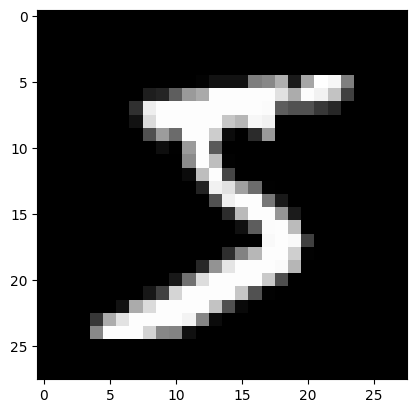

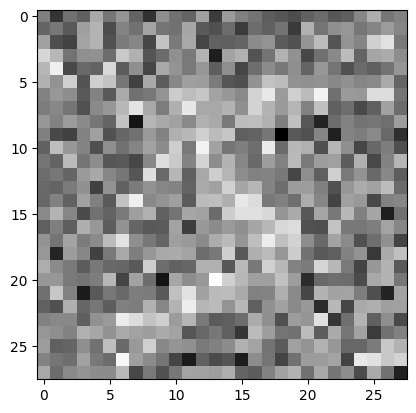

In [17]:

plt.figure()
plt.imshow(ground_truth.reshape(28,28),cmap='gray')
plt.figure()
plt.imshow(RHS.reshape(28,28), cmap='gray')


current n =9999
current n =19999
current n =29999
current n =39999
current n =49999
current n =59999


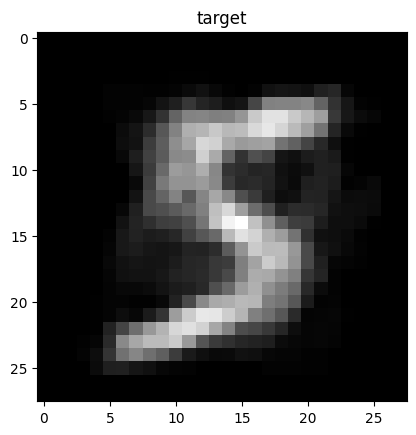

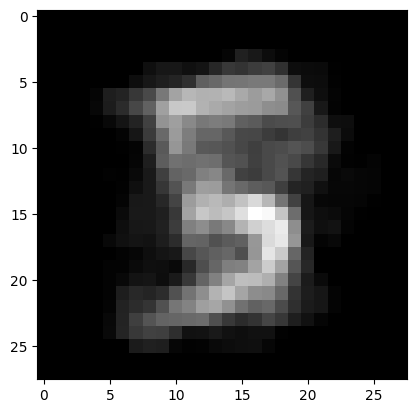

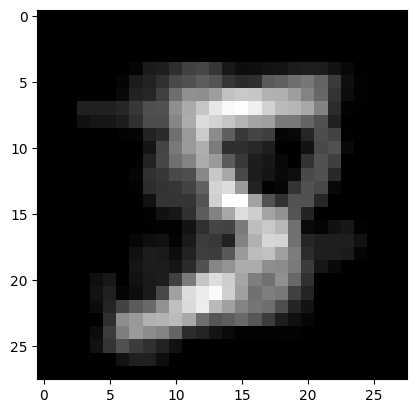

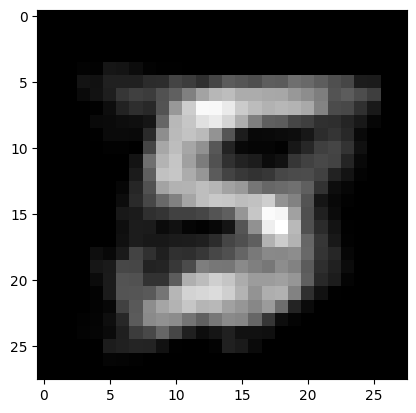

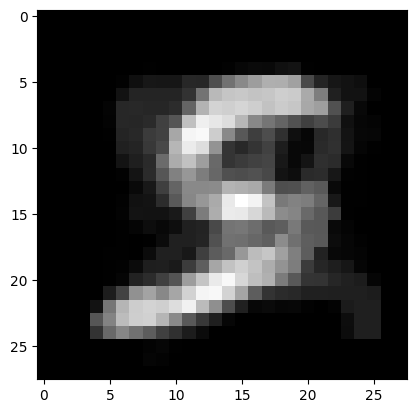

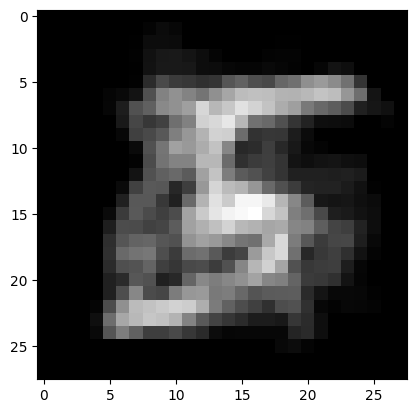

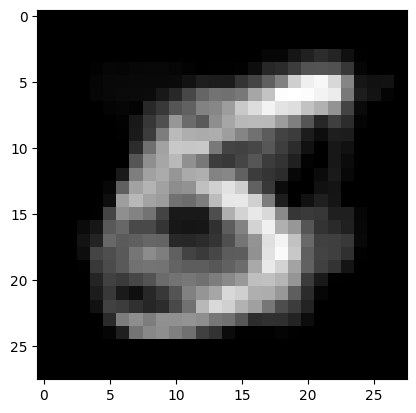

In [18]:
lam =0.1;
num_tests = [25];
testgrid = np.linspace(9999,59999,6)
result = np.zeros_like(testgrid)
latent_dim = 350;

A = vec_data
b = RHS
full_model = jl.KLLSModel(A,b);
jl.regularize(full_model,lam)

############################################


p = jl.solve(full_model, logging=0,max_time= 120.0,max_iter = 1000)
target_soln = A@p.solution
plt.figure()
plt.imshow(target_soln.reshape(28,28),cmap='gray')
plt.title('target')

del A,b,full_model,p
gc.collect()

transformer = rproj.GaussianRandomProjection(n_components=latent_dim)

#############################################

for (idx,n) in enumerate(testgrid):
    print('current n =' +str(int(n)));
    for test in num_tests:
        
        indices = np.random.choice(vec_data.shape[1], int(n), replace=False)
        sample_data = vec_data[:,indices]
        transformer.fit(sample_data.T)

        A = transformer.components_@(sample_data)
        b = transformer.components_@RHS

        testmodel = jl.KLLSModel(A,b);
        jl.regularize(testmodel,lam)
        p = jl.solve(testmodel, logging=0,max_time= 120.0,max_iter = 1000)

        result[idx] = result[idx] + np.linalg.norm(sample_data@p.solution - target_soln)/(np.linalg.norm(target_soln)*float(test))

        del A,testmodel,b
        gc.collect()
    
    plt.figure()
    plt.imshow((sample_data@p.solution).reshape(28,28),cmap ='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title("n = " + str(int(n)))

    del sample_data, p
    gc.collect


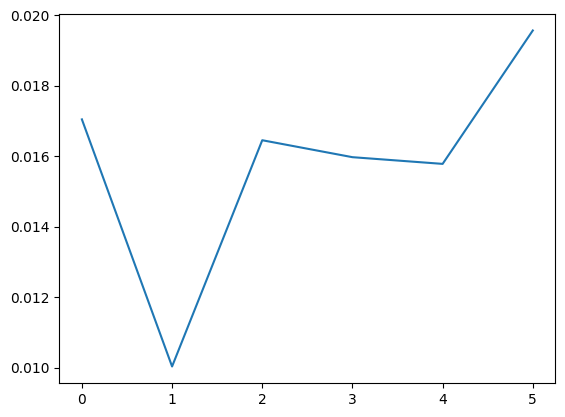

In [19]:


plt.plot(result)


# Garbage from here onwards
Instead work with BFGS

In [9]:
def objective(q,g):
    value = jl.dObj(testmodel,q)
    gradient_value = jl.dGrad(testmodel,q,g)
    return [value, gradient_value]

def scalar_obj(q):
    value = jl.dObj(testmodel,q)
    return value


In [10]:
y_init = np.zeros(latent_dim)
g = np.zeros(latent_dim)

result_opt = optimize.minimize(objective,y_init, args = g,method='L-BFGS-B',jac = True,options={'disp': True,'ftol':4e-16,'gtol':4e-7})
x_final = jl.dGrad(testmodel,result_opt.x,g)- lam*result_opt.x +b

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          200     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.00000D+00    |proj g|=  3.62536D+00

At iterate    1    f= -8.42197D+01    |proj g|=  3.03288D+00

At iterate    2    f= -1.50122D+02    |proj g|=  1.94195D+00

At iterate    3    f= -1.74210D+02    |proj g|=  1.26802D+00

At iterate    4    f= -1.76857D+02    |proj g|=  4.92004D-01

At iterate    5    f= -1.78148D+02    |proj g|=  3.35072D-01

At iterate    6    f= -1.78370D+02    |proj g|=  5.26629D-01

At iterate    7    f= -1.78713D+02    |proj g|=  2.44575D-01

At iterate    8    f= -1.78831D+02    |proj g|=  1.06659D-01

At iterate    9    f= -1.78880D+02    |proj g|=  5.66889D-02

At iterate   10    f= -1.78905D+02    |proj g|=  4.57014D-02

At iterate   11    f= -1.78908D+02    |proj g|=  5.43547D-02

At iterate   12    f= -1.78912D+02    |proj g|=  1.04281D-02

At iterate   13    f= -1.7

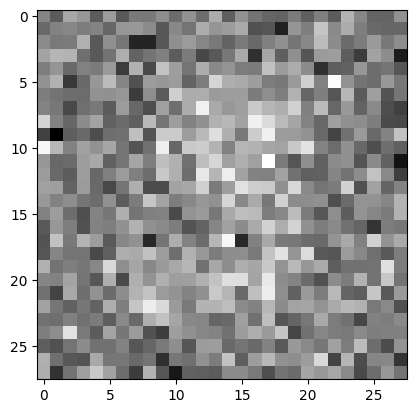

In [11]:

plt.imshow((x_final@matrix_test).reshape(28,28),cmap='gray')

In [12]:
np.linspace(10000,60000,6)

array([10000., 20000., 30000., 40000., 50000., 60000.])